In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, matthews_corrcoef, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.calibration import calibration_curve
cols = ['E', 'size_1', 'size_2', 'xc_1', 'yc_1', 'xc_2', 'yc_2',
        'Xint', 'Yint', 'theta_int', 'nwidth', 'errorON', 'source_x', 'source_y', 
        'Xground', 'Yground'
]
exp_cols = ['size_1', 'size_2', 'xc_1', 'yc_1', 'xc_2', 'yc_2', 'theta_int', 'nwidth', 'errorON', ]
tel_coord =np.array([[108.52, -35.52], [91.3, -197.15], [1.01, 1.55]]) #First -- Xs, Second -- Ys

In [2]:
gamma_data = pd.read_csv("MC_gamma_BZA.csv", usecols=cols, index_col=False, dtype='float64')
hadron_data = pd.read_csv("MC_hadron_BZA.csv", usecols=cols, index_col=False, dtype='float64')
OFF_data = pd.read_csv("BZA_DF_OFF.csv", index_col=False, dtype='float64', usecols=cols[1:])
gamma_data.replace([np.inf, -np.inf], np.nan, inplace=True)
hadron_data.replace([np.inf, -np.inf], np.nan, inplace=True)
OFF_data.replace([np.inf, -np.inf], np.nan, inplace=True)
gamma_data = gamma_data.loc[(gamma_data.size_1 >150) & (gamma_data.size_2 > 150)]
hadron_data = hadron_data.loc[(hadron_data.size_1 > 150) & (hadron_data.size_2 > 150)]
OFF_data = OFF_data.loc[(OFF_data.size_1 > 150) & (OFF_data.size_2 > 150)]
gamma_data = gamma_data.loc[(abs(gamma_data.Xint) < 5) & (abs(gamma_data.Yint) < 5)]
hadron_data = hadron_data.loc[(abs(hadron_data.Xint) < 5) & (abs(hadron_data.Yint) < 5)]
OFF_data = OFF_data.loc[(abs(OFF_data.Xint) < 5) & (abs(OFF_data.Yint) < 5)]
gamma_data = gamma_data.loc[(abs(gamma_data.Xground) < 500) & (abs(gamma_data.Yground) < 500)]
hadron_data = hadron_data.loc[(abs(hadron_data.Xground) < 500) & (abs(hadron_data.Yground) < 500)]
OFF_data = OFF_data.loc[(abs(OFF_data.Xground) < 500) & (abs(OFF_data.Yground) < 500)]
gamma_data = gamma_data.loc[(abs(gamma_data.errorON) < 2.5)]
hadron_data = hadron_data.loc[(abs(hadron_data.errorON) < 2.5)]
OFF_data = OFF_data.loc[(abs(OFF_data.errorON) < 2.5)]

gamma_data.dropna(inplace=True)
hadron_data.dropna(inplace=True)
OFF_data.dropna(inplace=True)
OFF_data = OFF_data.sample(hadron_data.shape[0], random_state=42)
# OFF_data.drop([OFF_data.columns[0]], inplace=True)
OFF_data.index = np.arange(hadron_data.index[-1] + 1, hadron_data.index[-1] + 1 + OFF_data.shape[0])


In [3]:
gamma_data.shape

(4707, 16)

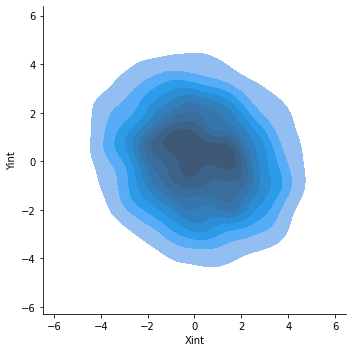

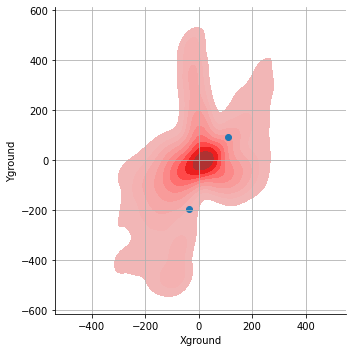

In [6]:
# fig, ax = plt.subplots(figsize=(6,6))
sns.displot(OFF_data, x="Xint", y="Yint", kind="kde", fill=True)
sns.displot(gamma_data, x="Xground", y="Yground", kind="kde", fill=True, color='red')
plt.scatter(tel_coord[0], tel_coord[1])
plt.grid()

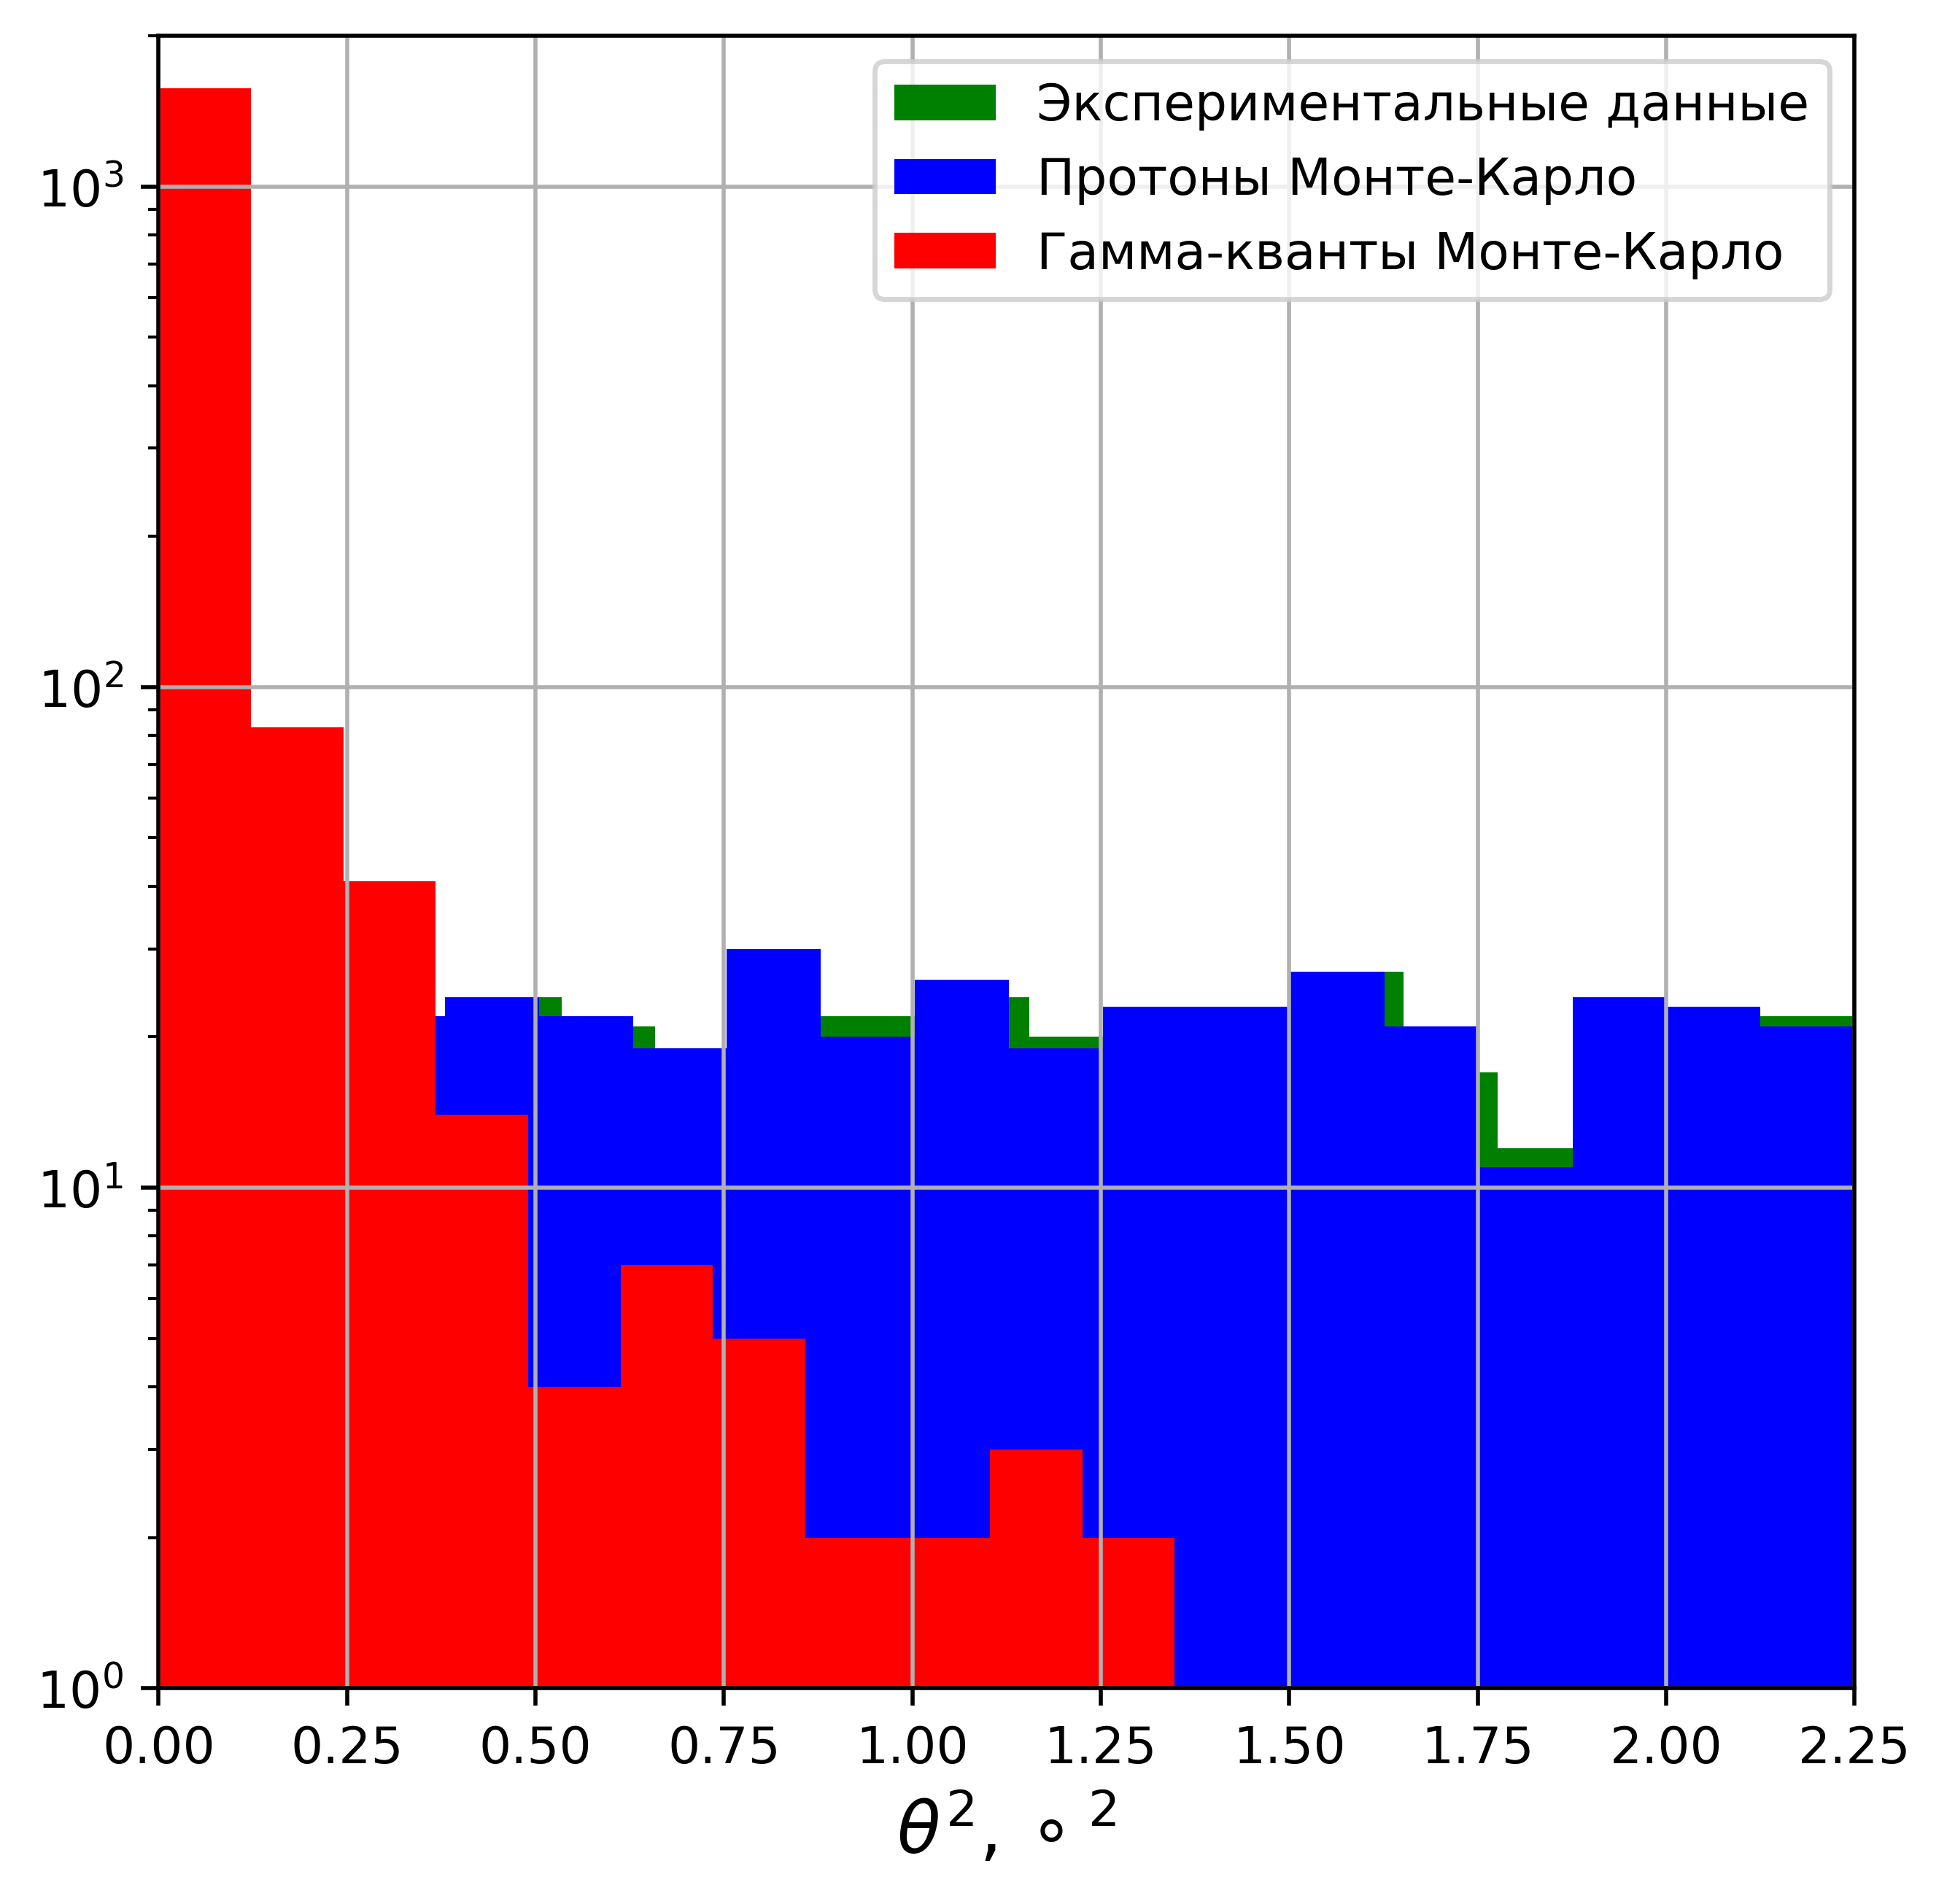

In [3]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(OFF_data.errorON**2, color= 'green', label = 'Экспериментальные данные', bins = 50)
ax.hist(hadron_data.errorON**2, color= 'blue', label = 'Протоны Монте-Карло', bins = 50)
ax.hist(gamma_data.errorON ** 2, color = 'red', label = 'Гамма-кванты Монте-Карло', bins = 50, log = True)
# plt.title("errorON")
ax.grid()
plt.xlabel(r"$\theta^2, \circ^2$", fontsize=14)
plt.xlim(0, 2.25)
ax.set_ylim(1, 2000)
fig.set_dpi(500)
plt.legend()
plt.savefig("theta2.svg", format='svg')

(1744, 16) (947, 16)


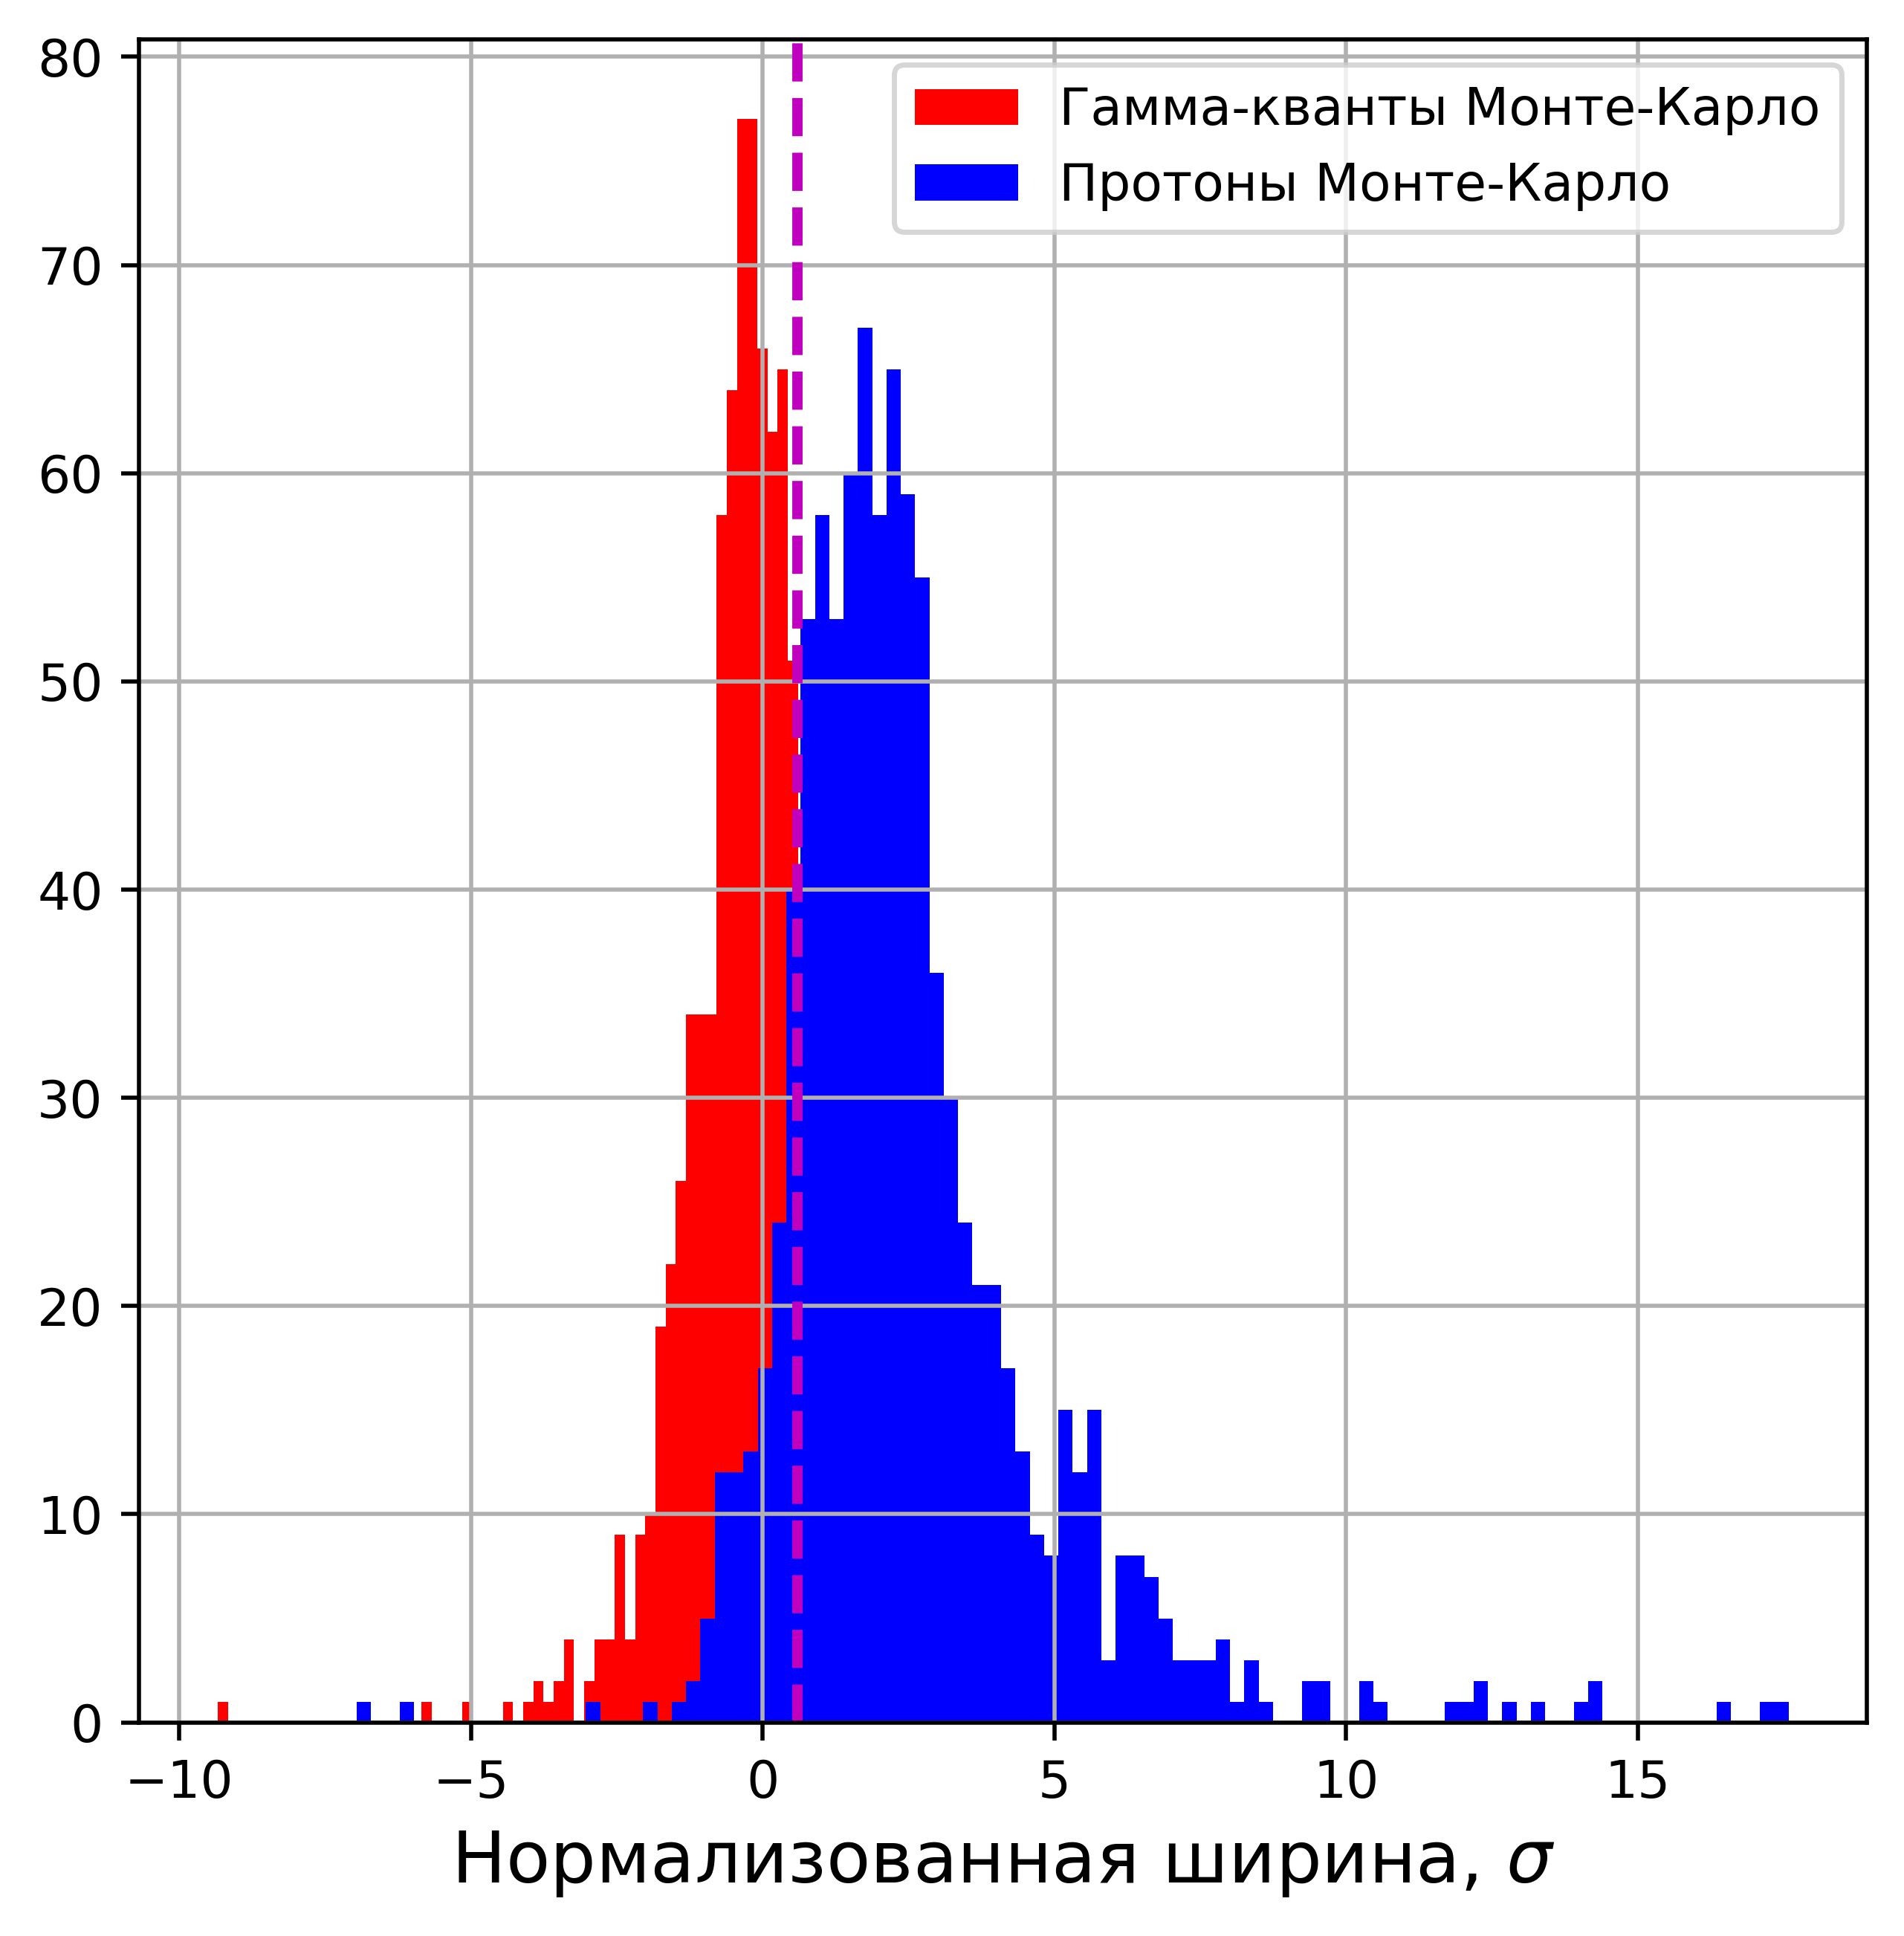

In [4]:
fig, ax = plt.subplots(figsize=(6, 6))
fig.set_dpi(500)

ax.hist(gamma_data.sample(hadron_data.shape[0], random_state=42).nwidth, color = 'red', label = 'Гамма-кванты Монте-Карло', bins = 100)
ax.hist(hadron_data.nwidth, color= 'blue', label = 'Протоны Монте-Карло', bins = 100)
print(gamma_data.shape, hadron_data.shape)
ax.axvline(linewidth=2, color='m', linestyle = '--', x=0.6, ymin=0, ymax=300)
# ax.hist(OFF_data.nwidth, color= 'green', label = 'Экспериментальные данные', bins = 50)
ax.grid()
ax.set_xlabel(r"Нормализованная ширина, $\sigma$", fontsize=14)
ax.legend()
plt.savefig("nwidth.svg", format='svg')

In [6]:
def train_and_test_regressor(models, X_train, Y_train, X_test, Y_test):
    for name, model in models.items():
        print(f"Fitting {name}")
        if name != "TabNet":
          model.fit(X_train, Y_train)
        else:
          model.fit(X_train, Y_train.reshape(-1, 1),
           eval_set = [(X_test,  Y_test.reshape(-1, 1))], max_epochs=30)
    predictions = {}
    for name, model in models.items():
        Y_pred = model.predict(X_test)
        predictions[name] = Y_pred
        
    boot_scores = {}

    for name, Y_pred in predictions.items():
        print(f"Calculating bootstrap score for {name}")
        boot_score = bootstrap_metric(Y_test, 
                                       Y_pred, 
                                       metric_fn=lambda X, Y: matthews_corrcoef(y_true=X, y_pred=Y))
        boot_scores[name] = boot_score
        
    
    results = pd.DataFrame(boot_scores)
    # cast to long format
    results = results.melt(value_vars=results.columns,
                       value_name="mse", 
                       var_name="model") 
    return results

def bootstrap_metric(X, 
                     Y, 
                     metric_fn,
                     samples_cnt = 1000,
                     random_state = 42):
    
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
        
        X_boot = X[poses]
        Y_boot = Y[poses]
        
        m_val = metric_fn(X_boot, Y_boot)
        b_metric[it] = m_val
    
    return b_metric

In [76]:
gamma_features = gamma_data[exp_cols]
hadron_features = OFF_data[exp_cols]
# hadron_features = pd.concat([hadron_data[exp_cols], OFF_data[exp_cols]], ignore_index=True)
y_gamma = pd.Series(np.ones(gamma_data.shape[0]), dtype='int')
y_hadron = pd.Series(np.zeros(hadron_features.shape[0]), dtype='int')

N_gamma = gamma_features.shape[0]
N_hadron = hadron_features.shape[0]
if (N_hadron >= N_gamma):
    N_train_and_test = 2 * N_gamma
    hadron_features = hadron_features.sample(n = N_gamma, random_state=42)
else:
    N_train_and_test = 2 * N_hadron
    gamma_features = gamma_features.sample(n = N_hadron, random_state=42)
N_of_each = int(N_train_and_test/2)    
x_gamma_train, x_gamma_test, y_gamma_train, y_gamma_test = train_test_split(gamma_features, y_gamma[:N_of_each], test_size=0.3, shuffle = True)
x_hadron_train, x_hadron_test, y_hadron_train, y_hadron_test = train_test_split(hadron_features, y_hadron[:N_of_each], test_size=0.3, shuffle = True)
print(x_hadron_train.describe())
print(x_hadron_test.describe())
x_train = pd.concat([x_hadron_train, x_gamma_train], ignore_index=True)
y_train = pd.concat([y_hadron_train, y_gamma_train], ignore_index=True)
x_test = pd.concat([x_hadron_test, x_gamma_test], ignore_index=True)
y_test = pd.concat([y_hadron_test, y_gamma_test], ignore_index=True)

             size_1        size_2        xc_1        yc_1        xc_2  \
count    662.000000    662.000000  662.000000  662.000000  662.000000   
mean     855.669622    978.671782   -0.602877   -0.604452    0.543777   
std     1279.850473   1481.686539    1.600702    1.491558    1.539055   
min      150.930000    150.540000   -3.886496   -3.995125   -3.572182   
25%      240.375000    263.910000   -1.817928   -1.698270   -0.594133   
50%      417.350000    453.940000   -0.644771   -0.624783    0.565865   
75%      893.812500    967.415000    0.527120    0.554316    1.674346   
max    12730.620000  12503.820000    3.536513    3.188784    4.130805   

             yc_2   theta_int      nwidth     errorON  
count  662.000000  662.000000  662.000000  662.000000  
mean     0.803124   58.655094    4.375939    1.641192  
std      1.411651   34.166954    4.778089    0.586039  
min     -2.696644    1.047919  -13.456175    0.208817  
25%     -0.202398   33.497684    1.431662    1.179779  
50%   

In [16]:
y_train

0       0
1       0
2       0
3       0
4       0
       ..
5757    1
5758    1
5759    1
5760    1
5761    1
Length: 5762, dtype: int64

In [65]:
XGBRF = xgboost.XGBClassifier(n_estimators=500,  
                     learning_rate=0.1, 
                     max_depth=5, 
                     random_state=42,
                     min_child_weight=9, # not exact analogue for min_samples_leaf
                     n_jobs=-1, # can be constructed in parrallel, much!!! faster) 
                     objective ='reg:squarederror')

RF = RandomForestClassifier(
    n_estimators=500,
    min_samples_split=2,
    max_depth=11, 
    bootstrap=True,
    max_features='sqrt',
     random_state=42,
)

# RF_scores = train_and_test_regressor({'RF':RF}, x_train, y_train, x_test, y_test)
# RF.fit(x_train, y_train)
models = {'RF':RF, 'XGB':XGBRF}

In [77]:
RF_scores = train_and_test_regressor(models, x_train, y_train, x_test, y_test)

Fitting RF
Fitting XGB


/home/alex/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Calculating bootstrap score for RF
Calculating bootstrap score for XGB


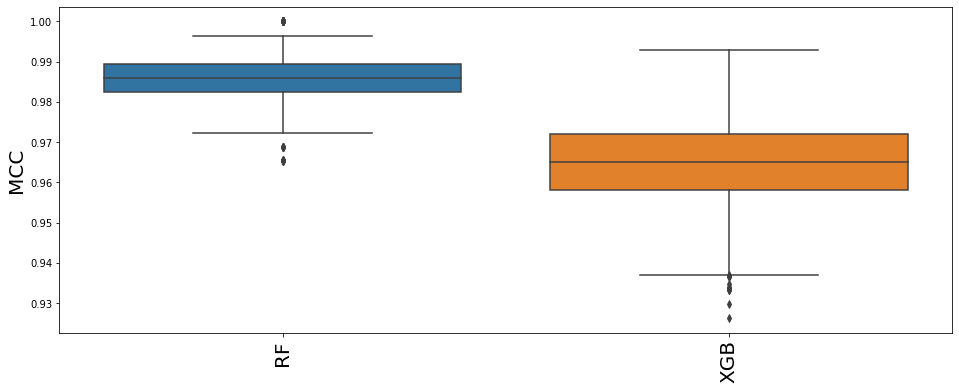

In [78]:
plt.figure(figsize=(16,6))
ax = sns.boxplot(data=pd.concat([RF_scores]) , y="mse", x="model")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel("", size=20)
plt.ylabel("MCC", size=20)

plt.xticks(size=20)
plt.show()

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

# Предсказанные классы тестовой выборки и вероятности тестовой выборки
classes_predicted = RF.predict(x_test)
print(classes_predicted.shape)
classes_probabilities = RF.predict_proba(x_test)
gamma_number = 0.95
# Матрица ошибок (по умолчанию она считается для гаммости = 0.5)
matrix = confusion_matrix(y_test, classes_predicted)
print(matrix)
# Меняем матрицу ошибок под установленное значение гаммости
N_g_h = matrix[0, 1]
N_h_h = matrix[1, 1]
if (RF.classes_[0] == 'gamma'):
    gamma_index = 0
    hadron_index = 1
else:
    gamma_index = 1
    hadron_index = 0
N_g_g = np.count_nonzero((classes_probabilities[:, gamma_index] >= gamma_number) & (y_test == 1))
N_h_g = np.count_nonzero((classes_probabilities[:, gamma_index] >= gamma_number) & (y_test == 0))
matrix[0, 0] = N_g_g
matrix[1, 0] = N_h_g
print(matrix)
E_g = N_g_g/float(N_g_g + N_g_h)
E_h = N_h_g/float(N_h_h + N_h_g)
Qfactor = E_g/(E_h**0.5)

print(matrix)
print(' E_g = %.10f, E_h = %.10f, Qfactor = %.10f' % (E_g, E_h, Qfactor))

(570,)
[[285   0]
 [  4 281]]
[[261   0]
 [  0 281]]


ZeroDivisionError: float division by zero

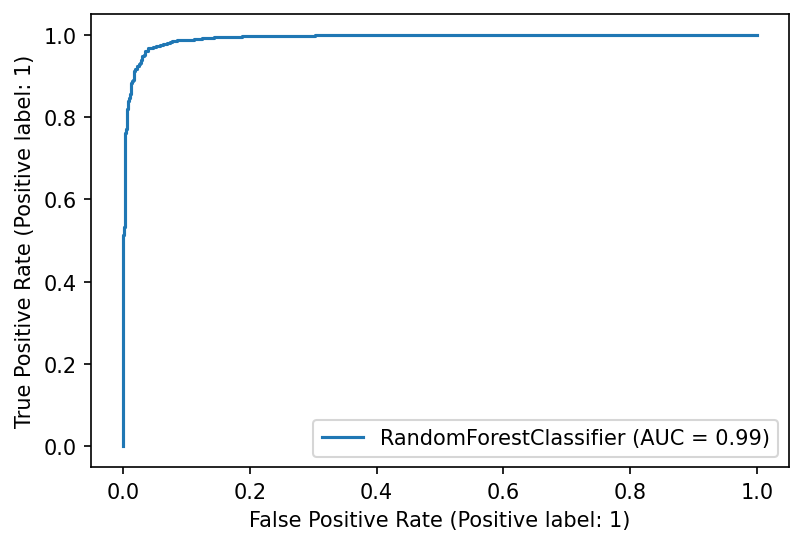

In [46]:
from sklearn import metrics
fig, ax = plt.subplots(figsize=(6,4), dpi = 150)
metrics.plot_roc_curve(RF, x_test, y_test, ax = ax)
# metrics.plot_roc_curve(XGBRF, x_test, y_test, ax = ax)


(array([227.,  24.,  11.,   4.,   4.,   6.,   0.,   2.,   2.,   1.,   1.,
          0.,   1.,   1.,   0.,   1.,   0.,   1.,   1.,   2.,   1.,   1.,
          0.,   0.,   2.,   0.,   1.,   2.,   0.,   2.,   3.,   0.,   0.,
          0.,   1.,   2.,   2.,   4.,   8., 252.]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   ]),
 <BarContainer object of 40 artists>)

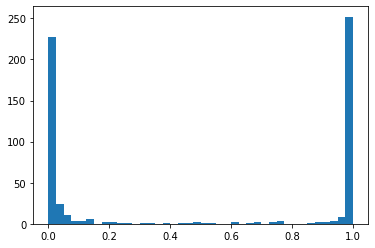

In [81]:
# RF.estimators_[11].predict_proba(x_test[:1])
predict = np.array([RF.estimators_[i].predict_proba(x_test)[:, 1] for i in range(RF.n_estimators)])
plt.hist(np.mean(predict.T, axis=1), bins =40)

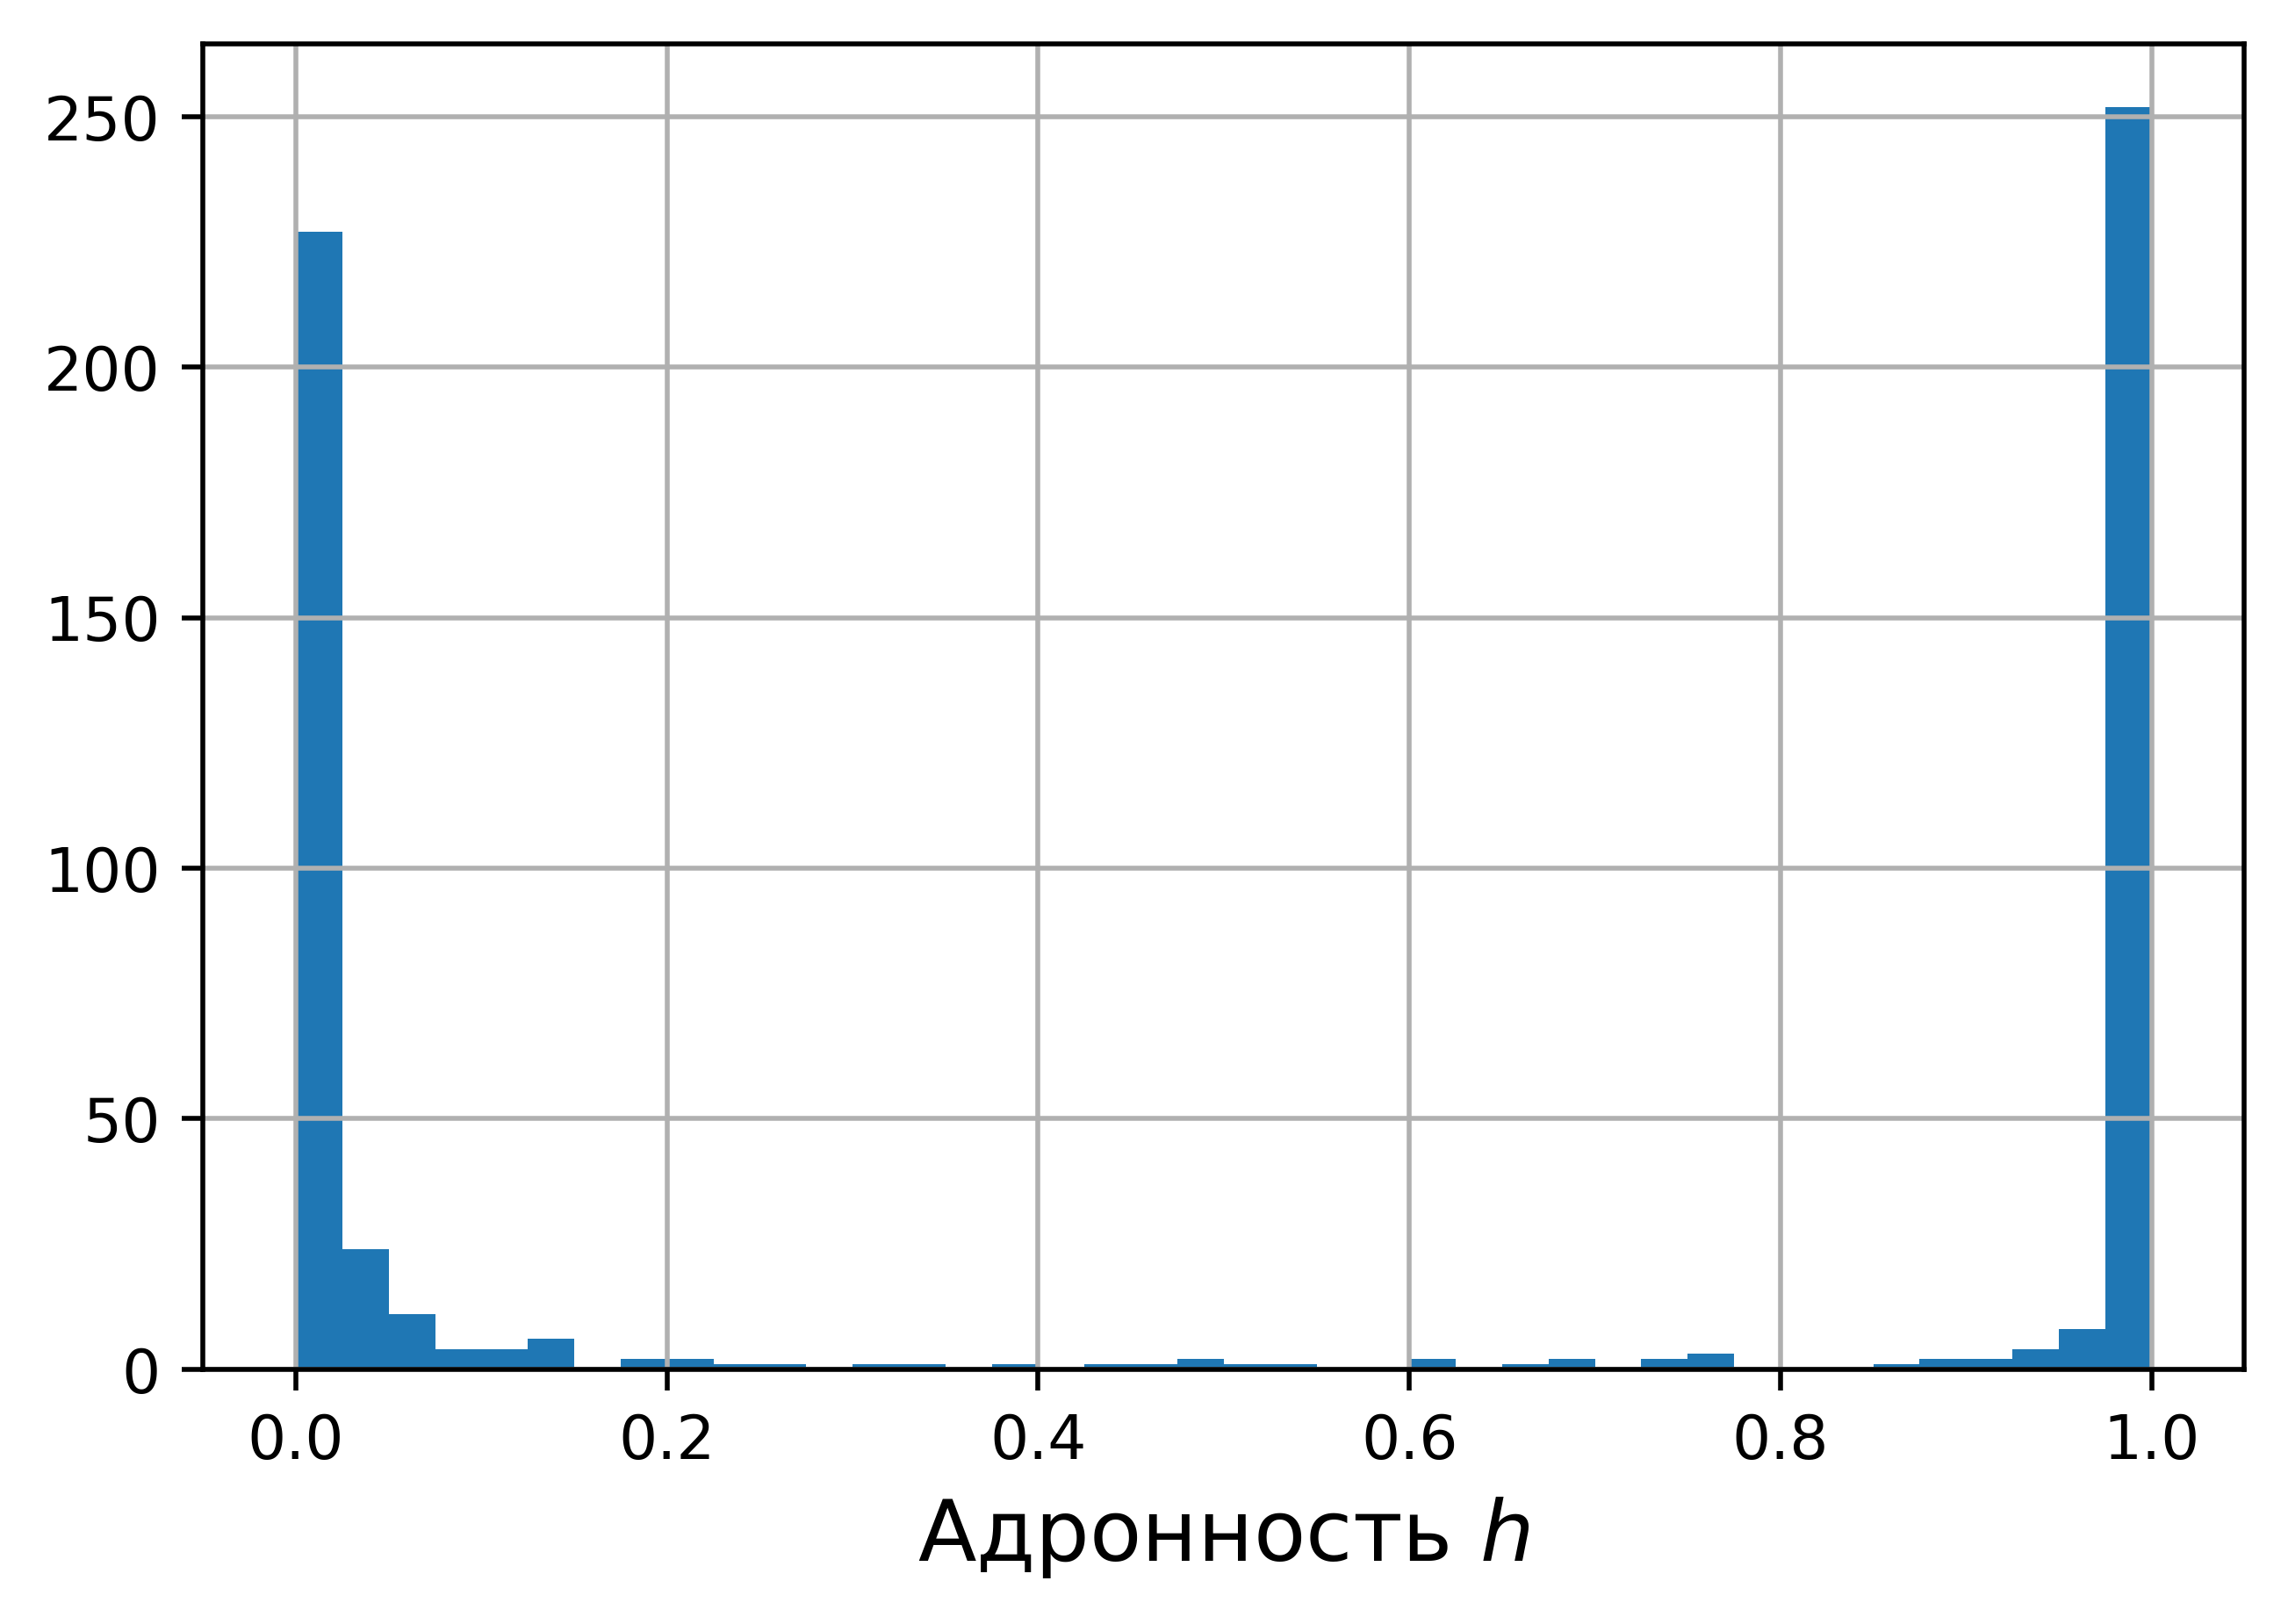

In [82]:
fig, ax = plt.subplots(dpi=500)

ax.hist(RF.predict_proba(x_test)[:, 1], bins = 40, label = 'RFClasifier')
# plt.hist(XGBRF.predict_proba(x_test)[:, 1], bins = 40, label = 'XGBRFClassifier')
ax.set_xlabel(r"Адронность $h$", fontsize=14)
ax.grid()
# plt.title('predict_proba results')

In [58]:
proba = XGBRF.predict_proba(x_test)
proba

array([[ 0.50602925,  0.49397075],
       [ 0.97386295,  0.02613704],
       [ 0.9940492 ,  0.00595082],
       ...,
       [-0.06013536,  1.0601354 ],
       [-0.01971209,  1.0197121 ],
       [ 0.03905797,  0.96094203]], dtype=float32)

[0.         0.00458716 0.28571429 0.         0.5        0.5
 0.5        0.75       1.         0.5        1.         1.        ]


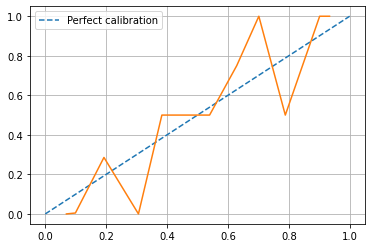

In [83]:
proba = XGBRF.predict_proba(x_test)
y_means, proba_means = calibration_curve(np.array(y_test), proba[:, 1], n_bins=12, strategy='uniform', normalize=True)
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect calibration')
plt.plot(proba_means, y_means)
plt.grid()
plt.legend()
print(y_means)

In [35]:
def eudist(a1, a2):
    return np.sqrt((a1[0] - a2[0]) ** 2 + (a1[1]-a2[1])**2)



In [84]:
exp_data = pd.read_csv("BZA_DF_20-21_fixed.csv", usecols = cols[1:], dtype = 'float64')
print(exp_data.shape)
exp_data["errorOFF"]=eudist((-exp_data["source_x"], -exp_data["source_y"]), (exp_data["Xint"], exp_data["Yint"]))
# exp_data[exp_data.errorOFF < 0.2].to_csv("BZA_DF_OFF.csv")
exp_data.replace([np.inf, -np.inf], np.nan, inplace=True)
exp_data = exp_data[exp_data.errorON < 5]
print(exp_data.shape)
exp_data = exp_data.loc[(abs(exp_data.Xint) < 5) & (abs(exp_data.Yint) < 5)]
print(exp_data.shape)
exp_data = exp_data.loc[(abs(exp_data.Xground) < 500) & (abs(exp_data.Yground) < 500)]
print(exp_data.shape)
exp_data.dropna(inplace=True)
print(exp_data.shape)
exp_data = exp_data[(exp_data.size_1 > 150) & (exp_data.size_2 > 150)]
print(exp_data.shape)
exp_data_ON = exp_data.loc[(abs(exp_data.errorON) < 0.5)]
# exp_data.describe()
exp_data_ON = exp_data_ON[exp_cols]
print("ON:", exp_data_ON.shape)
exp_data_OFF = exp_data.loc[(abs(exp_data.errorOFF) < .5)]
# exp_data.describe()
exp_data_OFF.loc[:, "errorON"] = exp_data_OFF.errorOFF
exp_data_OFF = exp_data_OFF[exp_cols]
print("OFF:", exp_data_OFF.shape)

# exp_data_new["errorOFF"] = eudist
# exp_data_new = exp_data_new.loc[(exp_data_new.size_1 > SIZE) & (exp_data_new.size_2 > SIZE)]
# exp_data_new = exp_data_new.loc[(exp_data_new.size_1 < 1e4) & (exp_data_new.size_2 < 1e4)]
exp_data_OFF.describe()
# probs = RF.predict_proba(exp_data_new)
# # for i in range(exp_data_new.shape[0]):
# #     if probs[i][0] >= gamma_number:
# #         exp_data_new["class"] = 'gamma'
# #     elif probs[i][0] <= 0.5:
# #         exp_data_new["class"] = 'hadron'
# #     else:
# #         exp_data_new["class"] = 'undefined'
# exp_data_new["class"] = "undefined"
# exp_data_new["class"].loc[probs[:, gamma_index] >= 0.75] = "gamma"
# exp_data_new["class"].loc[probs[:, gamma_index] <= 0.5] = "hadron"
# indx = exp_data_new[(exp_data_new["class"] == 'gamma')].index

(132189, 15)
(110053, 16)
(108999, 16)
(101281, 16)
(95070, 16)
(47443, 16)
ON: (1041, 9)
OFF: (957, 9)


/home/alex/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,size_1,size_2,xc_1,yc_1,xc_2,yc_2,theta_int,nwidth,errorON
count,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000,957.000000
mean,875.744033,1152.367377,-0.454488,-0.650715,0.668001,0.726137,59.934657,4.416283,0.334526
std,1409.517312,2883.928540,1.359893,1.329710,1.242102,1.228830,34.906857,5.093484,0.120593
min,150.480000,150.500000,-3.546761,-3.647832,-3.335292,-2.880942,1.436850,-18.286629,0.018148
25%,237.640000,230.680000,-1.460984,-1.688190,-0.163878,-0.147229,33.824542,1.401027,0.257751
50%,406.150000,411.270000,-0.443336,-0.731677,0.718655,0.722627,54.544722,2.838714,0.353983
75%,909.320000,1011.950000,0.463448,0.322413,1.507354,1.619667,81.681819,5.822589,0.436975
max,21025.850000,45226.610000,3.616616,3.199875,3.906361,3.725699,164.032022,19.889644,0.499749


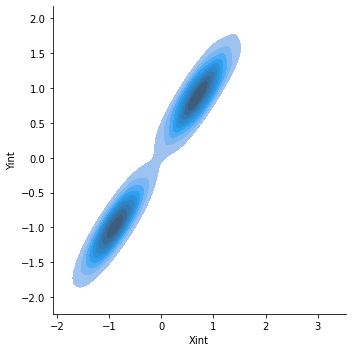

In [67]:
# exp_data.errorOFF[exp_data.errorOFF < 0.2]
sns.displot(exp_data[exp_data.errorON < 0.2], x="Xint", y="Yint", kind="kde", fill=True)

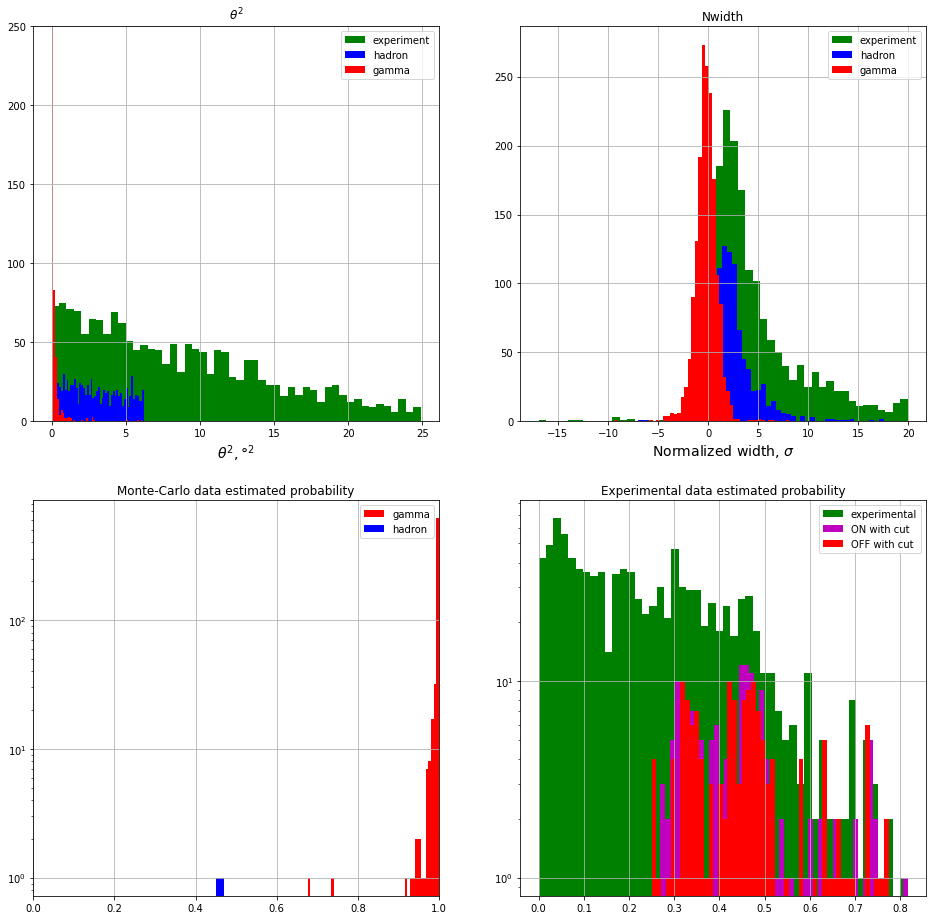

In [85]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16, 16))
hadron_features = hadron_features[hadron_features.errorON < 10]
ax[0, 0].hist(exp_data.sample(n = N_gamma, random_state=42).errorON**2, color = 'green', label = 'experiment', bins = 50)
ax[0, 0].hist(hadron_data.errorON**2, color= 'blue', label = 'hadron', bins = 50)
ax[0, 0].hist(gamma_data.errorON**2, color = 'red', label = 'gamma', bins = 50)
ax[0, 0].set_title(r"$\theta^2$")
ax[0, 0].legend()
ax[0, 0].grid()
ax[0, 0].set_ylim(top=250)
ax[0, 0].set_xlabel(r"$\theta^2, \degree^2$", fontsize=14)

ax[0, 1].hist(exp_data.sample(n = N_gamma, random_state=42).nwidth, color = 'green', label = 'experiment', bins = 50,)
ax[0, 1].hist(hadron_data.nwidth, color= 'blue', label = 'hadron', bins = 50)
ax[0, 1].hist(gamma_data.nwidth, color = 'red', label = 'gamma', bins = 50)
ax[0, 1].set_title("Nwidth")
ax[0, 1].legend()
ax[0, 1].grid()
ax[0, 1].set_xlabel("Normalized width, $\sigma$", fontsize=14)

ax[1, 0].hist(RF.predict_proba(gamma_features.loc[gamma_features.errorON < 0.2])[:, 1], color = 'red', label = 'gamma', bins = 50)
ax[1, 0].hist(RF.predict_proba(hadron_features.loc[hadron_features.errorON < 0.2])[:, 1], color = 'blue', label = 'hadron', bins = 50, log=True)
ax[1, 0].legend()
ax[1, 0].set_xlim([0, 1])
ax[1, 0].set_title("Monte-Carlo data estimated probability")
ax[1, 0].grid()

ax[1, 1].hist(RF.predict_proba(exp_data_ON)[:, 1], color = 'green', label = 'experimental', bins = 50, log=True)
ax[1, 1].hist(RF.predict_proba(exp_data_ON.loc[exp_data_ON.errorON < 0.2])[:, 1],
              color = 'm', label = 'ON with cut', bins = 50, log=True)
# ax[1, 1].hist(RF.predict_proba(exp_data_OFF)[:, 1], color = 'green', label = 'experimental', bins = 50, log=True)
ax[1, 1].hist(RF.predict_proba(exp_data_OFF.loc[exp_data_OFF.errorON < 0.2])[:, 1],
              color = 'r', label = 'OFF with cut', bins = 50, log=True)
ax[1, 1].set_title("Experimental data estimated probability")
ax[1, 1].grid()
ax[1, 1].legend()

# ax[1, 0] = sns.displot(exp_data, x="Xground", y="Yground", kind="kde", fill=True, color='red')
# plt.scatter(tel_coord[0], tel_coord[1])

In [86]:
proba_ON = RF.predict_proba(exp_data_ON.loc[exp_data_ON.errorON < 0.2])[:, 1]
proba_OFF = RF.predict_proba(exp_data_OFF.loc[exp_data_OFF.errorON < 0.2])[:, 1]

In [73]:
proba_OFF.shape

(150,)

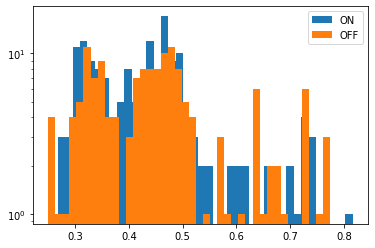

In [87]:
plt.hist(proba_ON, bins=40, log=True, label = "ON")
plt.hist(proba_OFF, bins=40, log=True, label = "OFF")
plt.legend()

In [89]:
def sigma(ON, OFF):
    return (ON - OFF)/np.sqrt(ON + OFF)
for g in np.arange(0.75, 1, 0.01):
    ON = len(proba_ON[proba_ON > g])
    OFF = len(proba_OFF[proba_OFF > g])
    print(g, ":", sigma(ON, OFF), ON, OFF)

0.75 : -0.8164965809277261 2 4
0.76 : -1.0 1 3
0.77 : 0.0 1 1
0.78 : 1.0 1 0
0.79 : 1.0 1 0
0.8 : 1.0 1 0
0.81 : 1.0 1 0
0.8200000000000001 : nan 0 0
0.8300000000000001 : nan 0 0
0.8400000000000001 : nan 0 0
0.8500000000000001 : nan 0 0
0.8600000000000001 : nan 0 0
0.8700000000000001 : nan 0 0
0.8800000000000001 : nan 0 0
0.8900000000000001 : nan 0 0
0.9000000000000001 : nan 0 0
0.9100000000000001 : nan 0 0
0.9200000000000002 : nan 0 0
0.9300000000000002 : nan 0 0
0.9400000000000002 : nan 0 0
0.9500000000000002 : nan 0 0
0.9600000000000002 : nan 0 0
0.9700000000000002 : nan 0 0
0.9800000000000002 : nan 0 0
0.9900000000000002 : nan 0 0


<ipython-input-89-ca54ac7fbf2e>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (ON - OFF)/np.sqrt(ON + OFF)


In [111]:
import numpy as np
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(x_train)
X_test_scaled = ss.transform(x_test)
y_train = np.array(y_train)

In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled, y_train)
display(rfc.score(X_train_scaled, y_train))
# 1.0

1.0

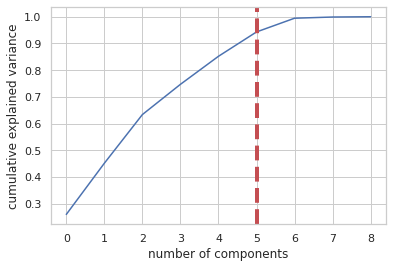

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.260312,0.260312
1,0.451794,0.191482
2,0.633956,0.182162
3,0.747086,0.113130
4,0.852039,0.104952
5,0.943144,0.091105
6,0.994495,0.051351
7,0.998951,0.004456
8,1.000000,0.001049


In [117]:
import seaborn as sns
from sklearn.decomposition import PCA
pca_test = PCA(n_components=9)
pca_test.fit(X_train_scaled)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=5, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(11))

In [118]:
pca = PCA(n_components=5)
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [120]:
pca_dims = []
for x in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(x))
pca_test_df = pd.DataFrame(pca_test.components_, columns=exp_cols, index=pca_dims)
pca_test_df.head(10).T

,PCA Component 0,PCA Component 1,PCA Component 2,PCA Component 3,PCA Component 4,PCA Component 5,PCA Component 6,PCA Component 7,PCA Component 8
size_1,0.019389,0.393750,0.172636,0.203911,0.512368,-0.664374,0.257892,-0.052720,0.000728
size_2,0.026895,0.040128,0.413747,0.193686,0.554691,0.677762,0.142084,-0.041621,0.001274
xc_1,-0.509198,-0.336541,0.324861,-0.022539,0.006567,-0.144794,0.017036,0.238459,-0.665773
yc_1,0.484923,-0.411641,0.263217,0.029630,0.048104,-0.164691,0.007325,0.662506,0.238401
xc_2,-0.505694,-0.354479,0.311946,-0.030239,-0.020634,-0.143185,0.014420,-0.245384,0.662604
yc_2,0.484729,-0.440722,0.217204,0.003661,-0.017332,-0.152028,-0.003857,-0.662815,-0.246697
theta_int,-0.024224,0.007443,0.040785,0.904597,-0.405984,0.024654,0.118163,0.000729,-0.002040
nwidth,0.065933,0.383014,0.528863,-0.005773,-0.173006,-0.052143,-0.732402,-0.012650,0.000578
errorON,0.094050,0.306587,0.445358,-0.316643,-0.481622,0.064932,0.601965,0.003697,-0.001023


In [121]:
rfc = RandomForestClassifier()
rfc.fit(X_train_scaled_pca, y_train)
display(rfc.score(X_train_scaled_pca, y_train))

1.0

In [124]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train_scaled_pca, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 700,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 11,
 'bootstrap': True}

In [125]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,700,2,2,log2,11,True,0.954009,1
1,700,12,2,sqrt,13,False,0.951406,2
2,600,23,2,sqrt,15,False,0.950365,3
3,700,23,7,log2,15,False,0.948977,4
4,1000,12,7,sqrt,10,True,0.948629,5
5,400,23,2,sqrt,14,False,0.948282,6
6,300,28,7,log2,13,True,0.945679,7
7,400,23,12,sqrt,11,True,0.945332,8
8,1000,44,2,sqrt,9,True,0.944811,9
9,800,28,12,sqrt,14,True,0.944464,10


In [131]:
rfc_5 = RandomForestClassifier(
n_estimators= 700,
 min_samples_split= 12,
 min_samples_leaf= 2,
 max_features= 'sqrt',
 max_depth= 13,
 bootstrap = False
)
rfc_5.fit(X_train_scaled_pca, y_train)
display(rfc_5.score(X_train_scaled_pca, y_train))

0.9866365845192642

In [141]:
exp_ON_scaled = ss.transform(exp_data_ON)
exp_OFF_scaled = ss.transform(exp_data_OFF)

In [142]:
exp_ON_pca = pca.transform(exp_ON_scaled)
exp_OFF_pca = pca.transform(exp_OFF_scaled)

In [143]:
proba_ON = rfc_5.predict_proba(exp_ON_pca)[:, 1]
proba_OFF = rfc_5.predict_proba(exp_OFF_pca)[:, 1]

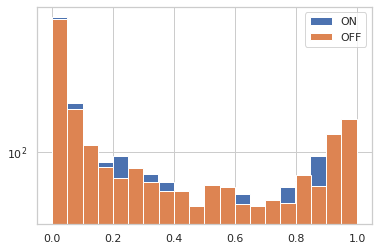

In [144]:
plt.hist(proba_ON, bins=20, log=True, label = "ON")
plt.hist(proba_OFF, bins=20, log=True, label = "OFF")
plt.legend()

In [145]:
def sigma(ON, OFF):
    return (ON - OFF)/np.sqrt(ON + OFF)
for g in np.arange(0.88, 1, 0.01):
    ON = len(proba_ON[proba_ON > g])
    OFF = len(proba_OFF[proba_OFF > g])
    print(g, ":", sigma(ON, OFF))

0.88 : 0.12298800925361816
0.89 : -0.08436490812191956
0.9 : -0.3942971589044912
0.91 : -0.5500190982169268
0.92 : -0.6276459144608478
0.93 : -0.7144345083117604
0.9400000000000001 : -0.329292779969071
0.9500000000000001 : -0.11909826683508273
0.9600000000000001 : -0.13018891098082389
0.9700000000000001 : -1.1149412193707495
0.9800000000000001 : -1.3112201362143716
0.9900000000000001 : -1.8083888603589302


In [146]:
exp_data_ON.shape, exp_data_OFF.shape

((2062, 9), (2007, 9))